In [2]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset. 
# implemented a MplClassifier using a simple neural network. 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import time 
import numpy as np

In [3]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT/IOT_Datasets/mems_dataset.csv')


# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21563 entries, 0 to 21575
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       21563 non-null  float64
 1   y       21563 non-null  float64
 2   z       21563 non-null  float64
 3   label   21563 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 842.3 KB


In [4]:
# X-axis: Represents acceleration along the horizontal axis.
# Y-axis: Represents acceleration along the vertical axis.
# Z-axis: Represents acceleration along the depth axis.

# labels 
#1. Normal: This label represents the state of the machine when it is operating under normal conditions, without any significant mechanical imbalance or impending failure.
#2. Near-failure: This label indicates that the machine is experiencing conditions that suggest it is close to a failure state. These conditions may include early signs of mechanical imbalance or other issues that could lead to failure if not addressed.
#3. Failure: This label is assigned when the machine has reached a state of failure, where it is no longer functioning as intended due to mechanical issues or other problems.


# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
1    10955
2     5771
3     4837
Name: count, dtype: int64


In [5]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [6]:
start_time = time.time()
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # initialization for MLPClassifier
    nn_model = MLPClassifier(
        hidden_layer_sizes=(50, 50),  
        activation='relu',            # Rectified Linear Unit (ReLU)
        solver='adam',                
        alpha=0.0001,                  # L2 regularization term
        batch_size='auto',             # Auto-adjust batch size based on the size of the dataset
        learning_rate='constant',      # Constant learning rate
        learning_rate_init=0.001,      # Initial learning rate
        max_iter=1000,                 # Maximum number of iterations
        random_state=42,               
        early_stopping=False,          # Disable early stopping
        verbose=True                   # Print progress messages during training
    )
    
    # Train 
    start_train_time = time.time()
    nn_model.fit(X_train, y_train)
    train_time = time.time() - start_train_time

    
    # Make predictions 
    start_pred_time = time.time()    
    y_pred_encoded = nn_model.predict(X_test)
    pred_time = time.time() - start_pred_time

total_time = time.time() - start_time

RuntimeError: Bad StatusOr access: INTERNAL: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 51041271808

In [6]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training: 1.64 seconds
Time taken for prediction: 0.00 seconds
Total time taken: 2.63 seconds


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6477044365435152


In [8]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred_encoded))


Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.84      0.72      3287
           2       0.75      0.70      0.72      1731
           3       0.52      0.14      0.23      1451

    accuracy                           0.65      6469
   macro avg       0.63      0.56      0.56      6469
weighted avg       0.63      0.65      0.61      6469



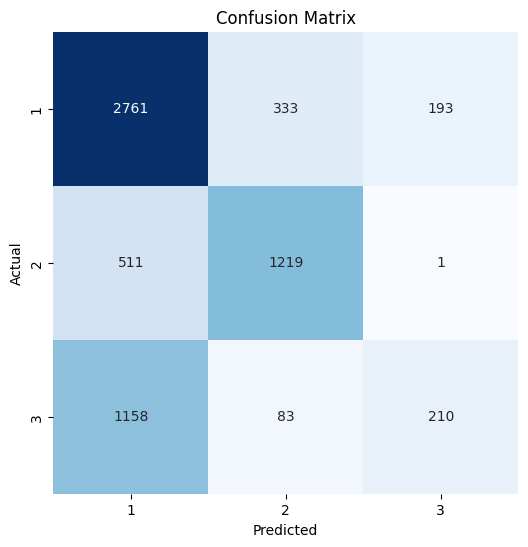

In [9]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred_encoded)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test, y_pred_encoded)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_3877964/843601881.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


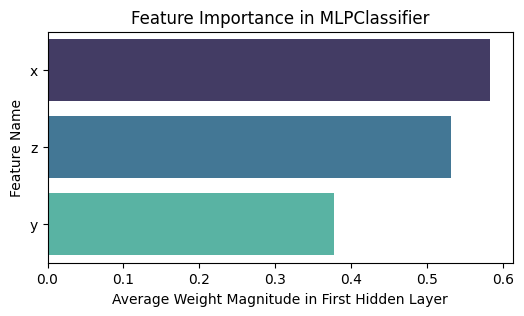

In [10]:
# Extract weights from the first hidden layer
weights_first_hidden_layer = nn_model.coefs_[0]

# Calculate feature importance based on the weights
feature_importance = np.abs(weights_first_hidden_layer).mean(axis=0)

# Create a DataFrame for visualization
importance_dict = dict(zip(X.columns.values, feature_importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

# Visualize the feature importance
plt.figure(figsize=(6, 3))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='mako')
plt.xlabel('Average Weight Magnitude in First Hidden Layer')
plt.ylabel('Feature Name')
plt.title('Feature Importance in MLPClassifier')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_encoded)
# precision = precision_score(y_test, y_pred_encoded)
# recall = recall_score(y_test, y_pred_encoded)
# f1 = f1_score(y_test, y_pred_encoded)
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print("Prediction Evaluation:")
print("Accuracy:".format(accuracy))
# print("Precision: ".format(precision))
# print("Recall: ".format(recall))
# print("F1-score: ".format(f1))
print("Confusion Matrix:")
print(conf_matrix)


Prediction Evaluation:
Accuracy:
Confusion Matrix:
[[2761  333  193]
 [ 511 1219    1]
 [1158   83  210]]


In [15]:

# Optionally, plot ROC curve and precision-recall curve
fpr, tpr, _ = roc_curve(y_test, y_pred_encoded)
precision, recall, _ = precision_recall_curve(y_test, y_pred_encoded)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Overall Performance Summary
print("\nOverall Performance Summary:")
print("The model's accuracy on the test set is {:.2f}".format(accuracy))
print("The model's precision on the test set is {:.2f}".format(precision))
print("The model's recall on the test set is {:.2f}".format(recall))
print("The model's F1-score on the test set is {:.2f}".format(f1))
print("The confusion matrix on the test set is:")
print(conf_matrix)


ValueError: multiclass format is not supported